In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/planets-dataset/planet/planet/sample_submission.csv
/kaggle/input/planets-dataset/planet/planet/train_classes.csv
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_39140.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_4849.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_18979.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_24790.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_30624.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_7922.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_33905.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_15492.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_16642.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_37288.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_9357.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_40104.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_1

In [3]:
# Importing the necessary libraries
import os
import pandas as pd
import numpy as np
import gc # Garbage collector module for memory management
from matplotlib import pyplot # For data visualization
from matplotlib.image import imread
import matplotlib.pyplot as plt
import cv2 # OpenCV for image manipulation
import tensorflow as tf
from tensorflow import keras # We need keras library
from tqdm import tqdm # To read in images in batches and see progress
from sklearn.model_selection import train_test_split # For the creation of training and validation sets
# Libraries for loading models
from tensorflow.keras.models import load_model
# Define model related parameters
from keras import optimizers
from keras.models import Sequential , Model
from keras.layers import Input , Dense , Dropout , Flatten
from keras.layers import Conv2D,MaxPooling2D , BatchNormalization
from keras.callbacks import EarlyStopping,ModelCheckpoint 
from keras.preprocessing.image import ImageDataGenerator # Used for Data augmentation
from keras import backend as K # For specialized and optimized tensor manipulation

In [4]:
# Defining the fbeta metric
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2
 
    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)
 
    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
 
    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall)/(beta_squared * precision + recall + K.epsilon())

In [6]:
# Loading the train and test datasets
train = pd.read_csv('../input/planet-understanding-the-amazon-from-space/train_v2.csv/train_v2.csv')
train.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [7]:
train.shape

(40479, 2)

In [8]:
test = pd.read_csv('../input/planet-understanding-the-amazon-from-space/sample_submission_v2.csv/sample_submission_v2.csv')
test.head()

image_name                                  tags
0     test_0  primary clear agriculture road water
1     test_1  primary clear agriculture road water
2     test_2  primary clear agriculture road water
3     test_3  primary clear agriculture road water
4     test_4  primary clear agriculture road water

In [9]:
test.shape

(61191, 2)

**EXPLORATORY DATA ANALYSIS**

In [ ]:
#Loading the image datasets
train_image = '/content/planet/planet/train-jpg'
test_image = '/content/planet/planet/test-jpg'
test_additional = '/content/test-jpg-additional'

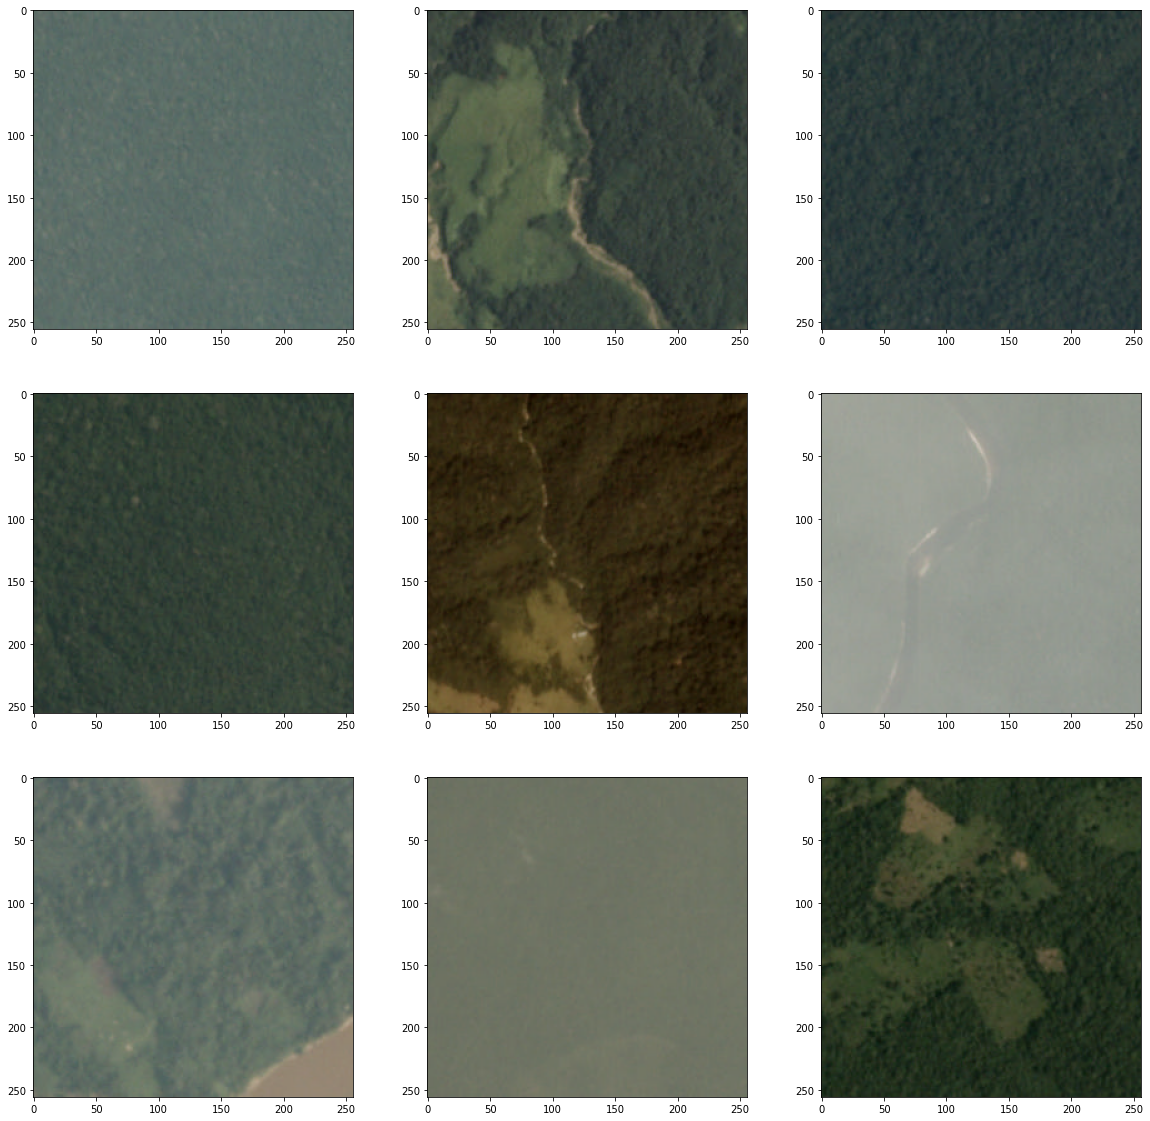

In [11]:
# Let's view some images
plt.figure(figsize=(20,20))
# define location of dataset
folder = '../input/planets-dataset/planet/planet/train-jpg/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'train_' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [12]:
#get number of unique classes in the train dataset
train['tags'].nunique()

449

In [14]:
# Flatten the 'tags' column of the training dataset into a list
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list (set(flatten([l.split (' ') for l in train['tags'].values])))

In [15]:
# Organise a label mapping
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}
label_map

{'habitation': 0,
 'cultivation': 1,
 'slash_burn': 2,
 'cloudy': 3,
 'conventional_mine': 4,
 'artisinal_mine': 5,
 'bare_ground': 6,
 'partly_cloudy': 7,
 'selective_logging': 8,
 'water': 9,
 'blow_down': 10,
 'haze': 11,
 'clear': 12,
 'agriculture': 13,
 'blooming': 14,
 'primary': 15,
 'road': 16}

In [16]:
gc.collect() #Frequently used to avoid session crashing due to memory exhaustion

46

**Data Preprocessing**

We preprocess the data so that it can be used to train the model. Reshape and normalize the images. One-hot encode the labels and split our training sets further into training and validation set using train_test_split

In [18]:
x_train = []
y_train = []

#read train images
labels = train['tags'].str.get_dummies(sep=' ').columns
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

for f, tags in tqdm(train.values, miniters = 1000):
  img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
  targets = np.zeros(17)
  for t in tags.split(' '):
    targets[label_map[t]] = 1
  x_train.append(cv2.resize(img, (32, 32)))
  y_train.append(targets)

#scale pixel values
x_train = np.array(x_train, np.float16)/255.
y_train = np.array(y_train, np.uint8)

100%|██████████| 40479/40479 [03:58<00:00, 169.86it/s]


In [19]:
len (x_train) 

40479

In [20]:
gc.collect()

97

In [25]:
# merge test-jpg and test-jpg-additional 
x_test = []
 
for img, label in tqdm(test[0:40669].values, miniters=1000):
    fil = cv2.resize(cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(img)), (64, 64))
    x_test.append(fil)
 
for img, label in tqdm(test[40669:].values, miniters=1000):
    fil = cv2.resize(cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(img)), (64, 64))
    x_test.append(fil)

100%|██████████| 20522/20522 [02:40<00:00, 127.72it/s]


In [26]:
len(x_test)

61191

In [27]:
gc.collect()

388

In [28]:
# Change lists to numpy arrays and normalize
x_train = np.array(x_train, np.float16)/255.
y_train = np.array(y_train, np.uint8)
x_test = np.array(x_test, np.float16)/255.

# Splitting the training dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True, random_state = 1)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(32383, 32, 32, 3) (32383, 17) (8096, 32, 32, 3) (8096, 17)


In [29]:
gc.collect()

46

**Building Model Architecture**

To tackle this multi-label problem, a combination of a custom deep CNN architecture along with the pre-trained CNN architecture(VGG16) was implemented in Keras with Tensorflow backend

In [30]:
input_size = 64
input_channels = 3
 

model = Sequential()

# Input layer
model.add(BatchNormalization(input_shape=(input_size, input_size, input_channels)))

# CCM_1
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#CCM_2
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
#CCM_3
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
#CCM_4
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Create a feature vector from the CCM_4 final layer
model.add(Flatten())

# Fully Connected (FC) Layer
model.add(Dense(512, activation='relu'))
model .add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(17, activation='sigmoid'))

2022-09-20 22:23:44.861144: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


**Loading Pre-trained CNN Architectures**

To supplement the custom CNN architecture,the pre-trained CNN architecture(VGG16) was implemented.

In [31]:
import tensorflow.keras as keras
# Loading the pre-trained VGG16 architecture module
from tensorflow.keras.applications.vgg16 import VGG16

# Extract the pre - trained architecture
base_model = VGG16(input_shape =(input_size,input_size,3),include_top =False,weights ='imagenet')
base_model.summary()

# Get the output of the base_model formed above
x = base_model.output
# Flatten to obtain a feature vector
x = Flatten()(x)
# Connect the feature vector to to the fully connected (FC) layer
x = Dense (512 , activation ='relu')(x)
# Form the output label predictions
predictions = Dense (17 , activation ='sigmoid')(x)
model = Model(inputs= base_model.input,outputs = predictions)

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [32]:
gc.collect()

2698

**Model Training**

In [33]:
# Implementing ImageDataGenerator for data augmentation. This is a very good technique which reduces overfitting as it generates extra images by flipping, zooming e,t.c the images. This makes the model have more images to learn from.
datagen = ImageDataGenerator ( horizontal_flip =True ,
vertical_flip =True ,
zoom_range =0.2,
rotation_range =90 ,
fill_mode ='reflect')

In [34]:
# Defining other parameters
epochs=20 # An epoch is one complete pass through the training data, We specify 20 here

opt = keras.optimizers.Adam(learning_rate=0.0001) # Defining our Adam optimizer and learning rate

In [35]:
#compile the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[fbeta])

callbacks = [EarlyStopping(monitor='val_loss',
                           patience=2,
                           verbose=0)]

In [36]:
gc.collect()

23

In [37]:
#fit the model
model.fit_generator(datagen.flow(x_train, y_train, batch_size =24),
steps_per_epoch =len(x_train)/32,
validation_data = datagen.flow (x_val, y_val, batch_size =24),
validation_steps =len(x_val)/32 ,
epochs =epochs, callbacks = callbacks, verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-09-20 22:24:24.342064: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


InvalidArgumentError:  Incompatible shapes: [6,17] vs. [24,17]
	 [[node gradient_tape/binary_crossentropy/logistic_loss/mul/BroadcastGradientArgs (defined at tmp/ipykernel_17/2451879985.py:6) ]] [Op:__inference_train_function_2182]

Function call stack:
train_function


In [38]:
gc.collect()

49

In [43]:
test_1 =[]
test_1.append (model.predict (x_test , batch_size = 24 , verbose =2) ) # Use the trained model for test data prediction

KeyboardInterrupt: 

In [40]:
gc.collect()

107

In [41]:
# After prediction, we compile the results in a pandas dataframe form
result = np.array(test_1[0])
for i in range(1,len(test_1)):
 result += np.array(test_1)
result = pd.DataFrame (result,columns = labels)
result

IndexError: list index out of range

In [ ]:
preds = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.loc[[i]]
    a = a.apply(lambda x: x > 0.2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))